
# CEWA 568 Snow Hydrology - Spring 2023
## Lab 4-2: Comparing snow flux and wind speed data at Kettle Ponds

Written by Eli Schwat (elilouis@uw.edu) - April 2023
Modified by Jessica Lundquist, including input from Ethan Gutmann

---

## Library imports

In [2]:
# import libraries we'll need
import urllib
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import os
%matplotlib inline

## User-provided inputs

Here we define a few variables to be used in the notebook. You may or may not want to change these values.

In [6]:
# Provide the path to a directory you want to download the SoS files to
download_directory = "../data/sosnoqc"

# Provide the paths to the precipitation file. This file was provided to you, you can either
# specify the path below or put the file in the same directory as this notebook.
precipitation_file = 'precipitation.nc'
windflux_file = 'sos_wind_snowflux.nc'

# Provide a the start and end dates you want to download
start_date = '20221201'
end_date = '20230327'

# Provide the specific variables you want to extract from the dataset.
# We provide these in advance because the datasets are very large and, 
# when we open them, we want to immediately extract only the data we want.
VARIABLES = [
    'spd_1m_ue',
    'spd_3m_ue',
    'spd_10m_ue',
    'SF_avg_1m_ue',
    'SF_avg_2m_ue'
]

## Load and open SoS Data

Note that the longer version of this lab walks you through downloading this data.  We will presume that you have downloaded it from the webpage and placed it in this working directory.

In [7]:
sos_dataset_60min=xr.open_dataset("sos_wind_snowflux.nc")

#### Check out our SoS dataset

Note that our `dataset` has just the variables we are defined. Note that `example_complete_dataset` has 1047 variables.

In [8]:
sos_dataset_60min

<xarray.Dataset>
Dimensions:       (time: 2808)
Coordinates:
  * time          (time) datetime64[ns] 2022-12-01 ... 2023-03-27T23:00:00
Data variables:
    spd_1m_ue     (time) float32 ...
    spd_3m_ue     (time) float32 ...
    spd_10m_ue    (time) float32 ...
    SF_avg_1m_ue  (time) float32 ...
    SF_avg_2m_ue  (time) float32 ...

## Plot
We use the Matplotlib library because integrates nicely with Xarray and makes creating simple plots quickly an easy task.

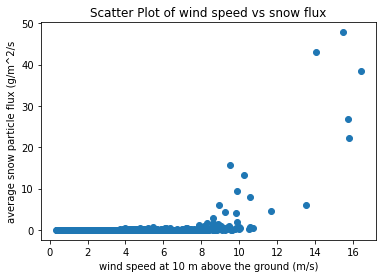

In [5]:
# create a scatter plot of 1 m particle flux vs 10 m wind speed
plt.scatter(sos_dataset_60min.spd_10m_ue, sos_dataset_60min.SF_avg_1m_ue)

# set axis labels and title
plt.xlabel('wind speed at 10 m above the ground (m/s)')
plt.ylabel('average snow particle flux (g/m^2/s')
plt.title('Scatter Plot of wind speed vs snow flux')

# show the plot
plt.show()

There definitely appears to be a threshold wind speed near 8 m/s, and I think our snow is fairly dry here.  However, there isn't a clear shape.  Maybe other wind speeds look better.  Remembering the need to filter in lab 4-1, we repeat that here.

In [12]:
def filter_outliers(data, perc=0.99):
  # calculate percentile 
  threshold = data.quantile(perc)
  # find outliers and replace them with max among remaining values 
  mask = data.where(abs(data) <= threshold)
  # max_value = mask.max().values
  # .where replace outliers with nan
  # mask = mask.fillna(max_value)
  data = mask
  return data

sos_dataset_60min['spd_1m_ue'] = filter_outliers(sos_dataset_60min['spd_1m_ue']).interp()

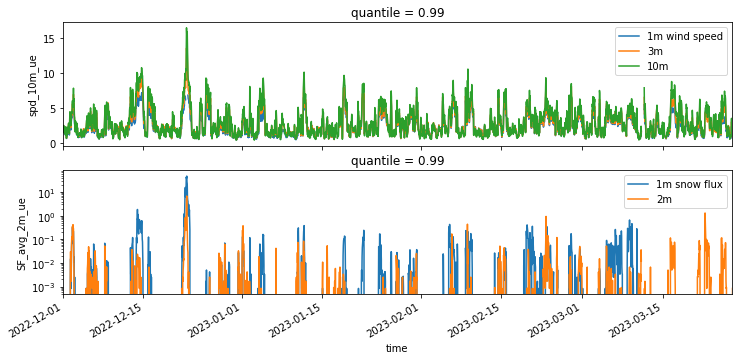

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12,5), sharex=True)
sos_dataset_60min['spd_1m_ue'].plot(ax=axes[0], label='1m wind speed')
sos_dataset_60min['spd_3m_ue'].plot(ax=axes[0], label='3m')
sos_dataset_60min['spd_10m_ue'].plot(ax=axes[0], label='10m')
sos_dataset_60min['SF_avg_1m_ue'].plot(ax=axes[1], label='1m snow flux')
sos_dataset_60min['SF_avg_2m_ue'].plot(ax=axes[1], label='2m')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("")
axes[1].set_yscale("log")
axes[0].set_xlim(dt.datetime(2022,12,1), dt.datetime(2023,3,27))
plt.show()

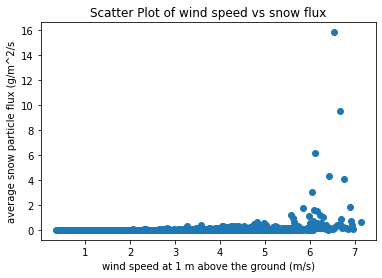

In [12]:
# create a scatter plot of 1 m particle flux vs 1 m wind speed
# maybe it's a better fit
plt.scatter(sos_dataset_60min.spd_1m_ue, sos_dataset_60min.SF_avg_1m_ue)

# set axis labels and title
plt.xlabel('wind speed at 1 m above the ground (m/s)')
plt.ylabel('average snow particle flux (g/m^2/s')
plt.title('Scatter Plot of wind speed vs snow flux')

# show the plot
plt.show()

Further investigate whether there are better combinations of wind speed and snow flux.  Investigate how wind speeds at different heights relate to each other.  

You can read a [scientific paper evaluating the FlowCapt sensors](https://doi.org/10.1175/JTECH-D-14-00104.1). This has some example plots of how we might want to evaluate our own sensors.  Based on our class discussion of how the FlowCapt particle flux sensors work, do you more trust the 1 m or 2 m measurements?  Or should these be combined?  Do the relationships change at different times in the snow season?  Why do you think this happens?

# BONUS:  How does lidar snow particle counts aloft compare to the FlowCapt sensors?

The dataset we import below gives us a particle count of snow moving aloft near the lidar sensors, which are each mounted at 10 m height.  We can investigate how these observations compare with snow measured by the rods near the ground.  

In [3]:
lidar_particles=xr.open_dataset("lidar_l2_particles.nc")

The dataset above was created by Ethan Gutmann at NCAR.  It contains a count of returns within a 1 meter distance that the lidar recorded over a 10 second period at the top of the hour.  This is lidar number 2, which is mounted on the upper east tower, the same one that has the FlowCapt sensors on it.  Because the lidar is mounted at 10 m height on the tower, this gives us an hourly 10-second particle count at an elevation 9-10 meters off the bare ground.  Note that the dataset includes returns from snowflakes during times when it is snowing in addition to blowing snow.

In [4]:
lidar_particles

<xarray.Dataset>
Dimensions:           (time: 3578)
Coordinates:
  * time              (time) datetime64[ns] 2022-10-12T18:00:00 ... 2023-03-2...
Data variables:
    suspended_points  (time) float64 ...

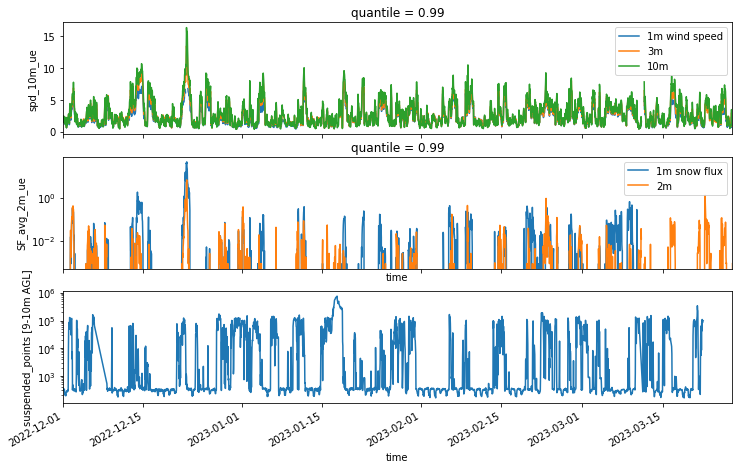

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(12,7), sharex=True)
sos_dataset_60min['spd_1m_ue'].plot(ax=axes[0], label='1m wind speed')
sos_dataset_60min['spd_3m_ue'].plot(ax=axes[0], label='3m')
sos_dataset_60min['spd_10m_ue'].plot(ax=axes[0], label='10m')
sos_dataset_60min['SF_avg_1m_ue'].plot(ax=axes[1], label='1m snow flux')
sos_dataset_60min['SF_avg_2m_ue'].plot(ax=axes[1], label='2m')
lidar_particles['suspended_points'].plot(ax=axes[2], label='10 m lidar snow flux')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("")
axes[1].set_yscale("log")
axes[2].set_yscale("log")
axes[0].set_xlim(dt.datetime(2022,12,1), dt.datetime(2023,3,27))
plt.show()